<a href="https://colab.research.google.com/github/PamelaVQ/Base-ML/blob/master/Pytorch_Basics/simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a simple autoencoder using pytorch

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch import nn
from torchvision import transforms
from torch.utils.data import dataloader
from torch.autograd import Variable

In [2]:
dataset = MNIST(root='.', download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [3]:
# create a dataloader
batch_size = 128
mnist_data = dataloader.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataset.data.shape, dataset.data.shape[1], dataset.data.shape[2])

torch.Size([60000, 28, 28]) 28 28


In [4]:
# create a simple autoencoder
class Encoder(nn.Module):
  def __init__(self, input_1, input_2):
    super(Encoder, self).__init__()
    self.linear1 = nn.Linear(input_1 * input_2, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 12)
    self.linear4 = nn.Linear(12, 3)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = torch.relu(self.linear4(x))
    # x = nn.Tanh()
    return x

class Decoder(nn.Module):
  def __init__(self, output_1, output_2):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(3, 12)
    self.linear2 = nn.Linear(12, 64)
    self.linear3 = nn.Linear(64, 128)
    self.linear4 = nn.Linear(128, output_1 * output_2)   

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = torch.relu(self.linear4(x))
    # x = nn.Tanh(x)
    return x


In [5]:
encoder = Encoder(dataset.data.shape[1], dataset.data.shape[2])
decoder = Decoder(dataset.data.shape[1], dataset.data.shape[2])

autoencoder = nn.Sequential(encoder, decoder)

In [6]:
x = Variable(torch.ones(batch_size, 784))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [128, 784]
Embedding [128, 3]
Output	  [128, 784]


In [26]:
model = autoencoder.cuda()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())
model.train()

Sequential(
  (0): Encoder(
    (linear1): Linear(in_features=784, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=12, bias=True)
    (linear4): Linear(in_features=12, out_features=3, bias=True)
  )
  (1): Decoder(
    (linear1): Linear(in_features=3, out_features=12, bias=True)
    (linear2): Linear(in_features=12, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=128, bias=True)
    (linear4): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [27]:
num_epochs = 100
epoch_loss = []
for epoch in range(num_epochs):
  batch_loss = []
  for batch_num, (data, _) in enumerate(mnist_data): # data = [128, 1, 28, 28]
    optim.zero_grad()
    data = data.view(data.shape[0], -1) # data = [128, 784]
    data = Variable(data).cuda()
    output = autoencoder(data)
    loss = loss_fn(output, data)
    loss.backward()
    optim.step()
    batch_loss.append(loss)
  epoch_loss.append(sum(batch_loss)/len(batch_loss))
  print(f'Epoch {epoch}:\tloss {epoch_loss[-1]:.4f}')

Epoch 0:	loss 0.9069
Epoch 1:	loss 0.9069
Epoch 2:	loss 0.9068
Epoch 3:	loss 0.9067
Epoch 4:	loss 0.9066
Epoch 5:	loss 0.9066
Epoch 6:	loss 0.9066
Epoch 7:	loss 0.9065
Epoch 8:	loss 0.9065
Epoch 9:	loss 0.9064
Epoch 10:	loss 0.9064
Epoch 11:	loss 0.9064
Epoch 12:	loss 0.9063
Epoch 13:	loss 0.9061
Epoch 14:	loss 0.9060
Epoch 15:	loss 0.9059
Epoch 16:	loss 0.9058
Epoch 17:	loss 0.9058
Epoch 18:	loss 0.9058
Epoch 19:	loss 0.9057
Epoch 20:	loss 0.9057
Epoch 21:	loss 0.9055
Epoch 22:	loss 0.9054
Epoch 23:	loss 0.9054
Epoch 24:	loss 0.9053
Epoch 25:	loss 0.9054
Epoch 26:	loss 0.9053
Epoch 27:	loss 0.9052
Epoch 28:	loss 0.9053
Epoch 29:	loss 0.9052
Epoch 30:	loss 0.9052
Epoch 31:	loss 0.9050
Epoch 32:	loss 0.9049
Epoch 33:	loss 0.9049
Epoch 34:	loss 0.9048
Epoch 35:	loss 0.9047
Epoch 36:	loss 0.9046
Epoch 37:	loss 0.9044
Epoch 38:	loss 0.9044
Epoch 39:	loss 0.9043
Epoch 40:	loss 0.9044
Epoch 41:	loss 0.9044
Epoch 42:	loss 0.9042
Epoch 43:	loss 0.9040
Epoch 44:	loss 0.9038
Epoch 45:	loss 0.903

In [58]:
def to_img(x):
    x = 0.5 * x + 0.5
    x = x.clamp(0, 1)
    x = x.view(x.shape[0], 1, 28, 28)
    return x

In [59]:
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

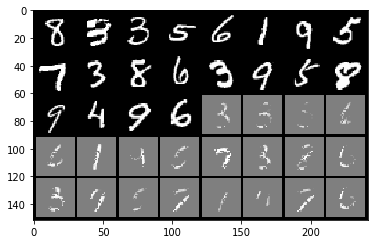

In [60]:
# print output
# also test with cuda
print_data = dataloader.DataLoader(dataset, batch_size=20, shuffle=True)
model = autoencoder.cuda()
from PIL import Image
for batch_num, (data, _) in enumerate(print_data):
    img1 = to_img(data)
    # show(make_grid(img))
    data = data.view(data.shape[0], -1)
    data = Variable(data).cuda()
    output = autoencoder(data)
    output = output.cpu()
    img = to_img(output)
    show(make_grid(torch.cat([img1, img])))
    break